In [2]:
# Core scverse libraries
import scanpy as sc
import anndata as ad

# Data retrieval
import pooch

In [3]:
sc.settings.set_figure_params(dpi=50, facecolor='white')

In [4]:
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache('scverse_tutorials'),
    base_url='doi:10.6084/m9.figshare.22716739.v1/',
)
EXAMPLE_DATA.load_registry_from_doi()

samples = {
    "s1d1": "s1d1_filtered_feature_bc_matrix.h5",
    "s1d3": "s1d3_filtered_feature_bc_matrix.h5",
}
adatas = {}

for sample_id, filename in samples.items():
    path = EXAMPLE_DATA.fetch(filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label='sample')
adata.obs_names_make_unique
print(adata.obs["sample"].value_counts())
adata

/Users/merlindassanayake/micromamba/envs/scanpy/lib/python3.11/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/merlindassanayake/micromamba/envs/scanpy/lib/python3.11/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/merlindassanayake/micromamba/envs/scanpy/lib/python3.11/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/merlindassanayake/micromamba/envs/scanpy/lib/python3.11/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


sample
s1d1    8785
s1d3    8340
Name: count, dtype: int64


/Users/merlindassanayake/micromamba/envs/scanpy/lib/python3.11/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 17125 × 36601
    obs: 'sample'

#### Quality Control

In [5]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.startswith("^HB[^(P)]")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=['mt', 'ribo', 'hb'], inplace=True, log1p=True
)

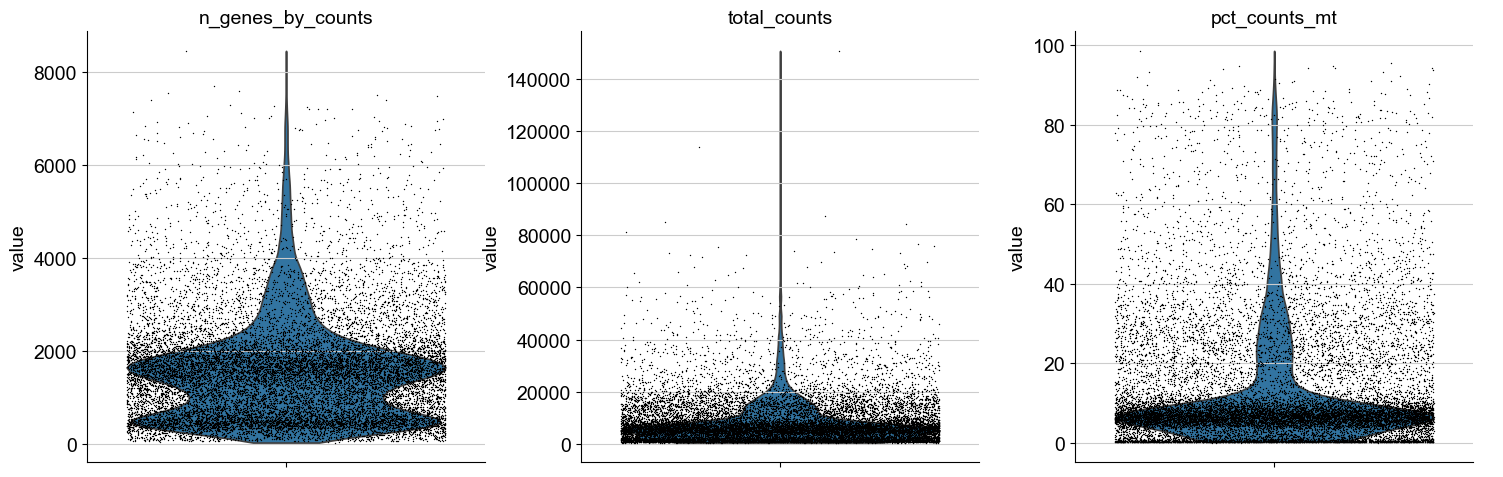

In [6]:
sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4,
    multi_panel=True,
)

##### We can now visualize QC metrics
- the number of genes expressed in the count matrix
- the total counts per cell
- the percentage of counts in mitochondiral genes

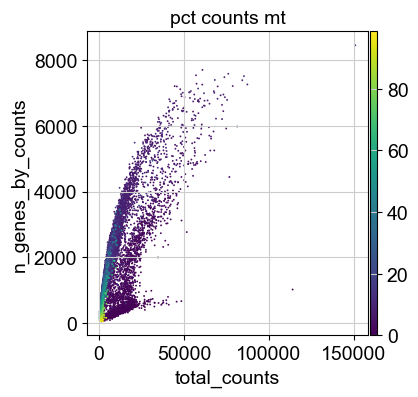

In [7]:
# We can also consider QC metrics jointly by inspecting a scatter plot colored by pct_counts_mt
sc.pl.scatter(adata, "total_counts",
              "n_genes_by_counts", color="pct_counts_mt")

In [8]:
# datasets with multiple batches need QC for each sample individually as the thresholds can vary between batches.
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

/Users/merlindassanayake/micromamba/envs/scanpy/lib/python3.11/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/merlindassanayake/micromamba/envs/scanpy/lib/python3.11/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### Doublet Detection
- Running doublet detection algo is crucial as they can lead to misclassifications or distortions downstream.
- Scanpy contains Scrublet, predicts doublets using nearest-neighbor classifier of observed transcriptomes and simulated doublets.
- scanpy.pp.scrublet() adds doublet_score and predicted_doublet to .obs. We can filter on either now directly.

In [9]:
# Had to install scikit-image with mamba
# Also removed batch key as I was running into errors
sc.pp.scrublet(adata)

/Users/merlindassanayake/micromamba/envs/scanpy/lib/python3.11/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### Normalization
The next preprocessing step is normalization. A common appraoch is count depth scaling with subsequent log plug one transformation. Count depth scaling normalizes the data to a size factor such as the median count depth, ten thousand (CP10k) or one million (CPM). Size factor controlled by target_sum in pp.normalize_total.

In [10]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [11]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

### Feature Selection
Next we want to reduce dimensionality to include most informative genes. Scanpy function pp.highly_variable_genes annotates highly variable genes.

In [12]:
sc.pp.highly_variable_genes(adata, n_top_genes=200, batch_key="sample")
sc.pp.highly_variable_genes(adata)

#### Dimensionality Reduction
Basically running PCA

In [13]:
sc.tl.pca(adata)

finding out how principle components are contributing to the total variance. Helps us figure out how many should be considered when doing leiden() or tsne()

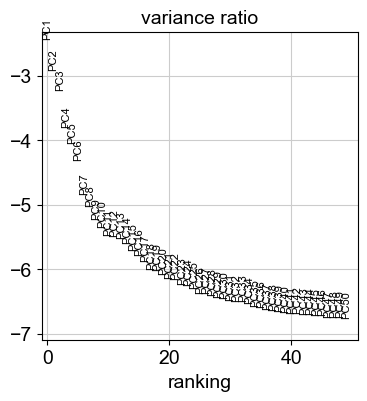

In [14]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

You can also plot the PC's to view undesired features driving significant variation in the dataset.

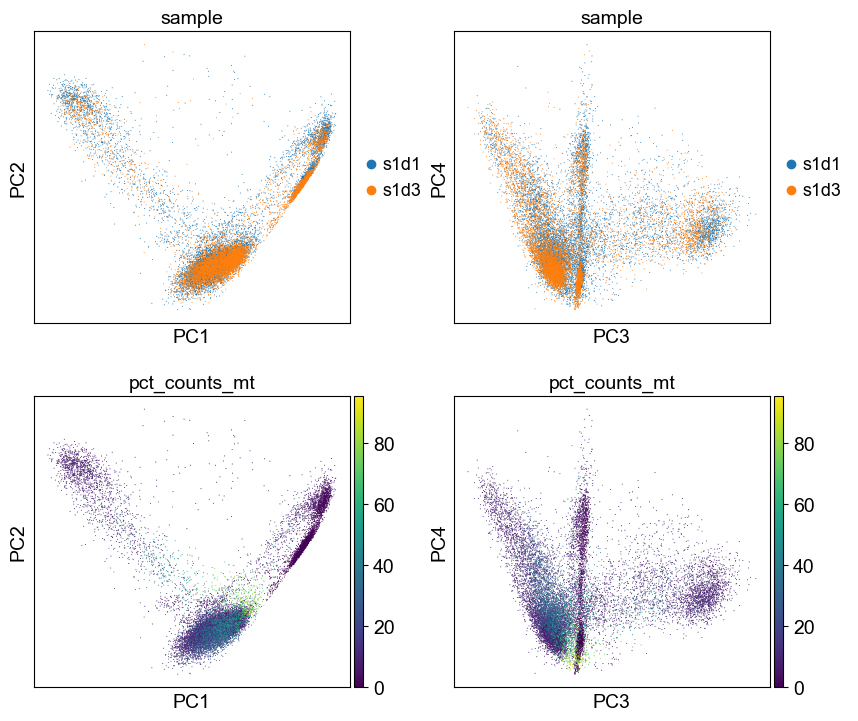

In [15]:
sc.pl.pca(
    adata,
    color = ['sample','sample','pct_counts_mt','pct_counts_mt'],
    dimensions = [(0,1), (2,3), (0,1), (2,3)],
    ncols = 2, 
    size = 2,
)

### Nearest Neighbor graph construction and visualization

In [16]:
sc.pp.neighbors(adata)

/Users/merlindassanayake/micromamba/envs/scanpy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
sc.tl.umap(adata)

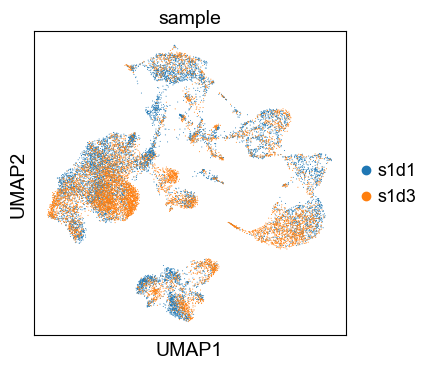

In [18]:
sc.pl.umap(
    adata,
    color = "sample",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

This data includes two different samples however there is only a minor batch effect and we can continue clustering and annotation. If there are batch effects in your UMAP its best to integrate across samples and perform batch correction/integration using scanorama and or scvi-tools for batch integration.

### Clustering

In [19]:
# using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor='igraph', n_iterations=2)

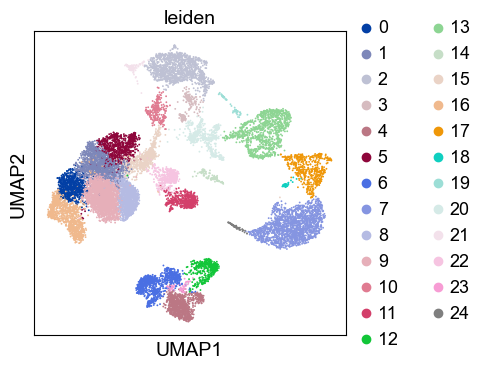

In [20]:
sc.pl.umap(adata, color=['leiden'])

#### Re-assess quality control and cell filtering
We can now re-assess filtering strategy by visualizing different QC metrics using UMAP

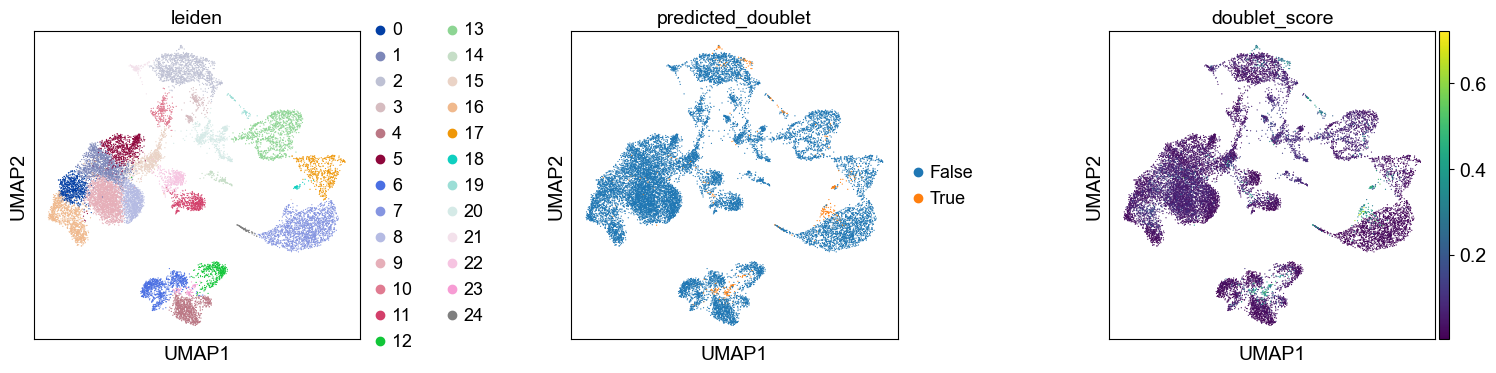

In [21]:
sc.pl.umap(
    adata,
    color = ['leiden','predicted_doublet','doublet_score'],
    #increase horizontial space between panels
    wspace=0.5,
    size=3,
)

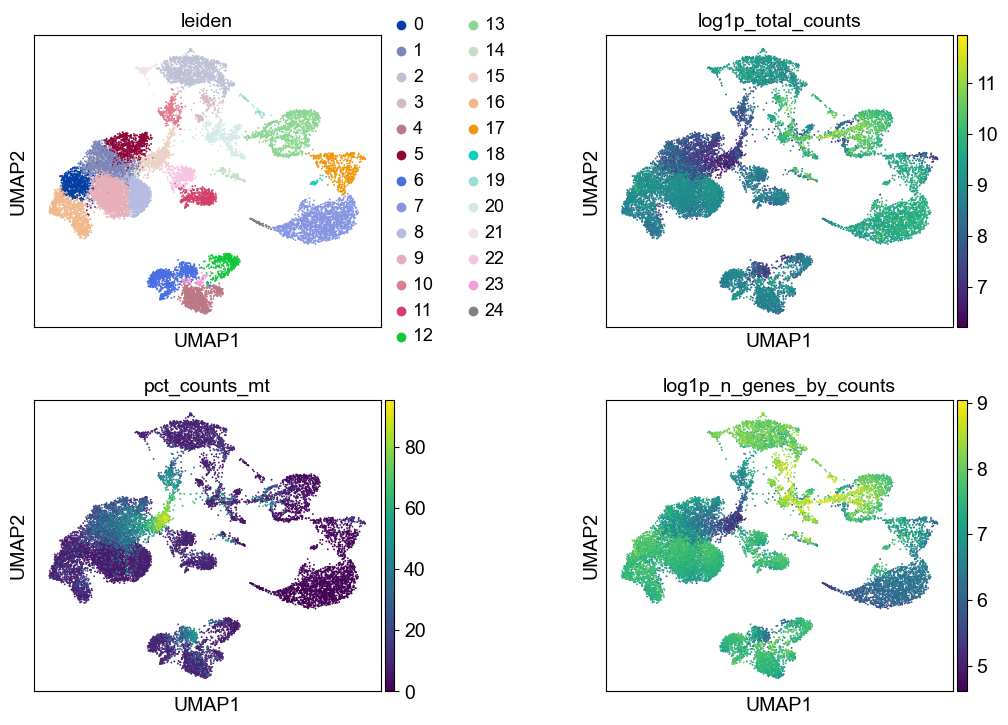

In [22]:
sc.pl.umap(
    adata,
    color=['leiden','log1p_total_counts','pct_counts_mt','log1p_n_genes_by_counts'],
    wspace = 0.5,
    ncols = 2,
)

### Manual cell-type annotation
Typically cell type annotation uses marker genes subsequent to the grouping of the cells into clusters. We will use Leiden clustering algorithm which will extract cell communities from our nearest neighbors.

In [ ]:
for res in [0.02, 0.5, 2.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor='igraph'
    )

The clusters we've defined as 0.02, 0.5, and 2.0 are mostly arbitrary in addition to the resolution parameter. Typically the number of clusters is bound to the stable and biologically-meaningful groups that we can ultimately distinguish.

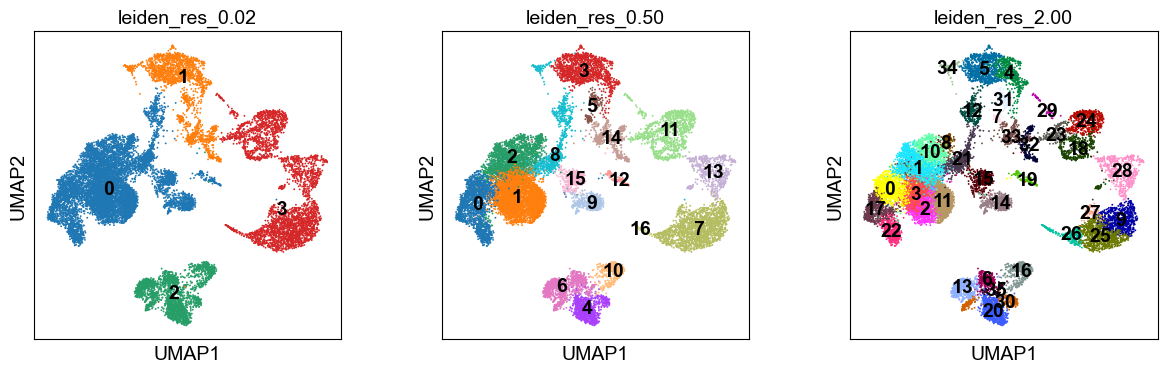

In [25]:
sc.pl.umap(
    adata,
    color=['leiden_res_0.02','leiden_res_0.50','leiden_res_2.00'],
    legend_loc='on data',
)

It's important to not overinterpret UMAP however we can see that the highest resolution, 2.00, is overclustering while the lowest resolution, 0.02, is grouping cells which belong to unique cell identities.

### Marker Gene Set
Define a set of marker genes for the main cell types that we expect to see in this dataset.

In [26]:
marker_genes = {
    "CD14+ Mono": ["FCN1", "CD14"],
    "CD16+ Mono": ["TCF7L2", "FCGR3A", "LYN"],
    # Note: DMXL2 should be negative
    "cDC2": ["CST3", "COTL1", "LYZ", "DMXL2", "CLEC10A", "FCER1A"],
    "Erythroblast": ["MKI67", "HBA1", "HBB"],
    # Note HBM and GYPA are negative markers
    "Proerythroblast": ["CDK6", "SYNGR1", "HBM", "GYPA"],
    "NK": ["GNLY", "NKG7", "CD247", "FCER1G", "TYROBP", "KLRG1", "FCGR3A"],
    "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
    "Naive CD20+ B": ["MS4A1", "IL4R", "IGHD", "FCRL1", "IGHM"],
    # Note IGHD and IGHM are negative markers
    "B cells": [
        "MS4A1",
        "ITGB1",
        "COL4A4",
        "PRDM1",
        "IRF4",
        "PAX5",
        "BCL11A",
        "BLK",
        "IGHD",
        "IGHM",
    ],
    "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
    # Note PAX5 is a negative marker
    "Plasmablast": ["XBP1", "PRDM1", "PAX5"],
    "CD4+ T": ["CD4", "IL7R", "TRBC2"],
    "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
    "T naive": ["LEF1", "CCR7", "TCF7"],
    "pDC": ["GZMB", "IL3RA", "COBLL1", "TCF4"],
}

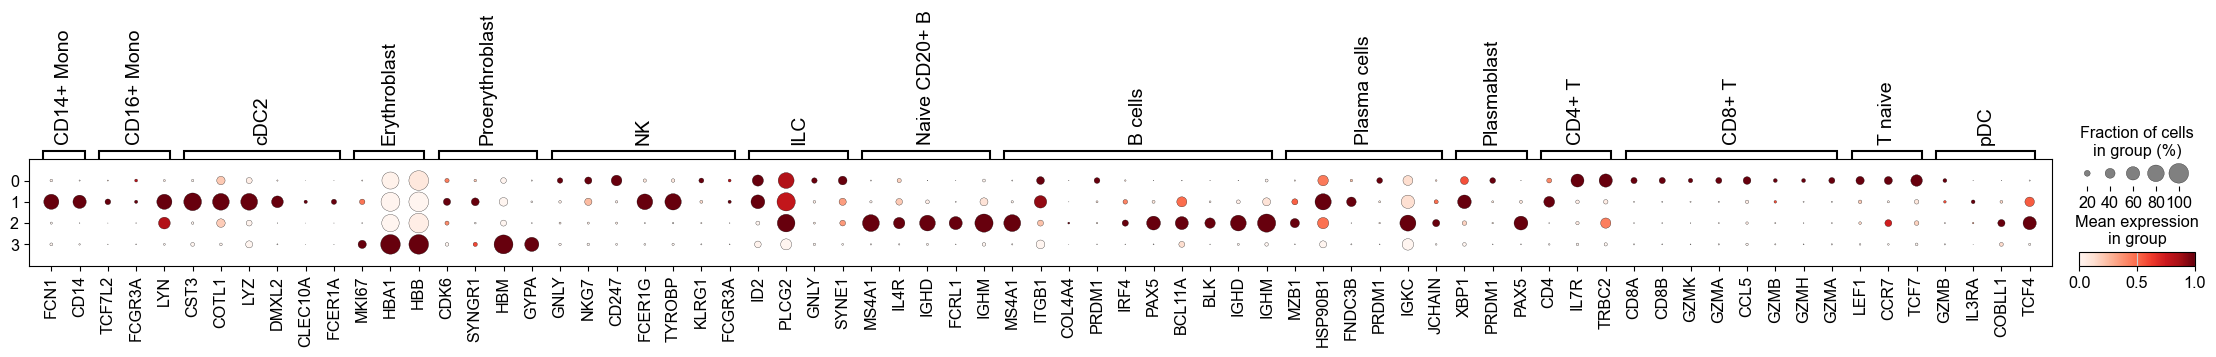

In [28]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden_res_0.02', standard_scale='var')

There are some clear patterns of expression for the markers which can be used to label our coarest clustering with broad lineages. 

In [29]:
adata.obs['cell_type_lvl1']=adata.obs['leiden_res_0.02'].map(
    {
    '0':'Lymphocytes',
    '1':'Monocytes',
    '2':'Erythroid',
    '3':'B Cells'
    }
)

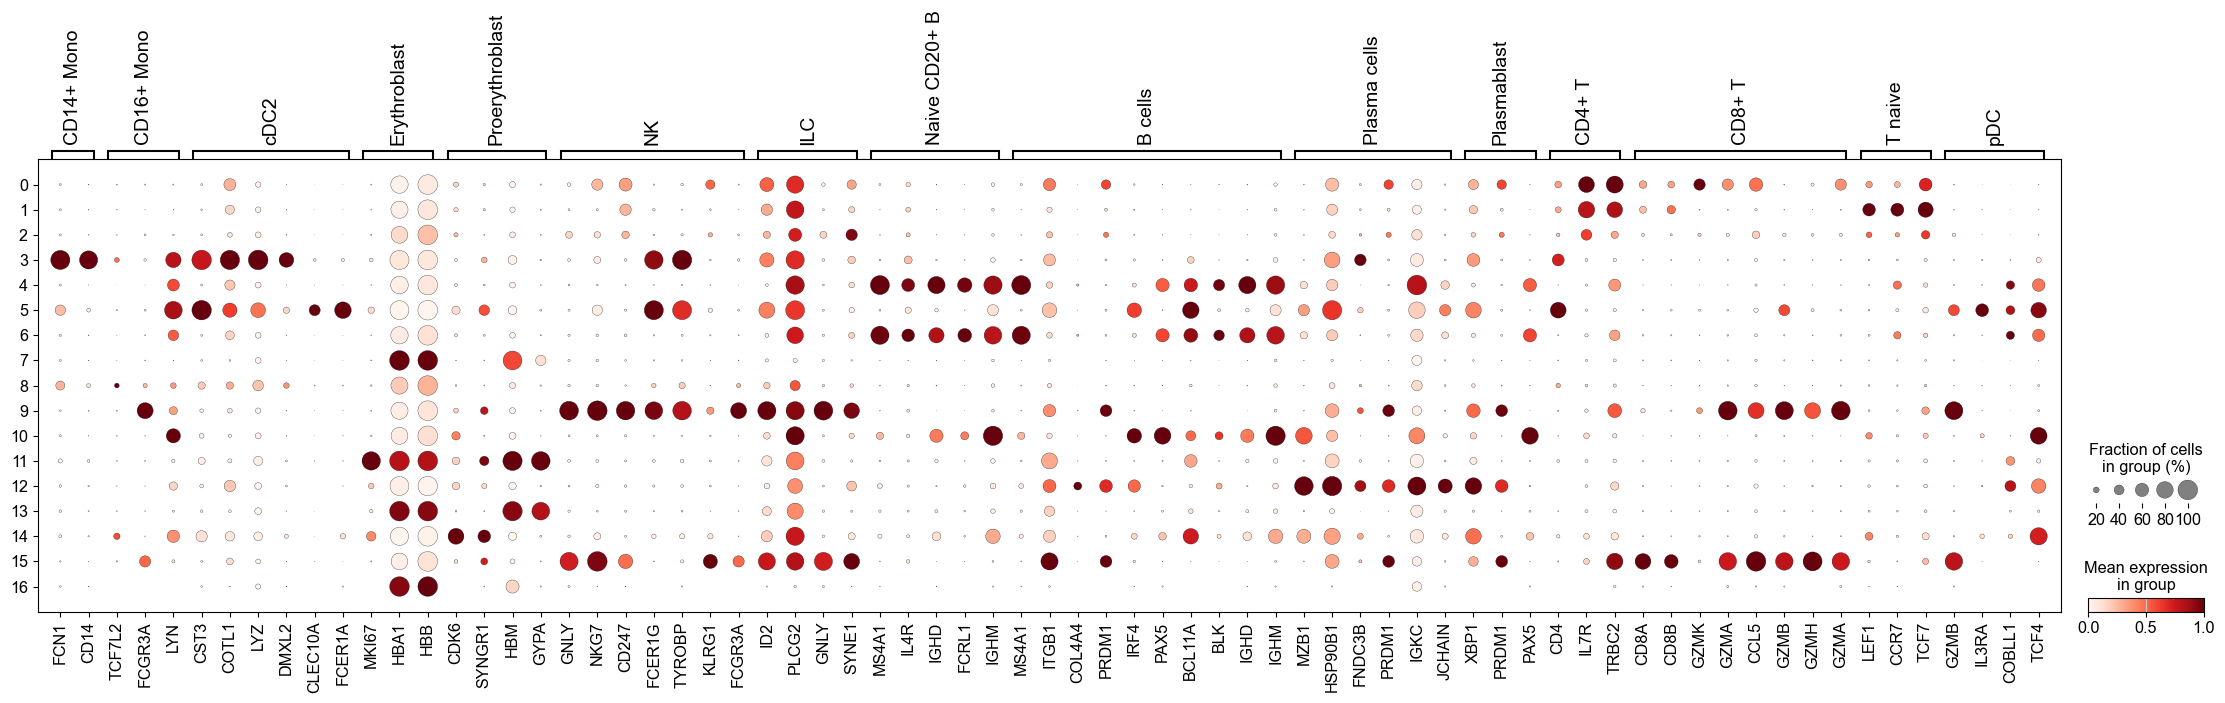

In [30]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden_res_0.50', standard_scale='var')

This seems like a resolution that is suitable to distinguish most of the different cell types in our data.

#### Differentially-expressed Genes as Markers
We can also calculate marker genes per cluster and then look up if we can link those marker genes to any known biology such as cell types or states.

This is typically done using statistical tests such as a Wilcoxon and t-test for each cluster vs the rest.

In [31]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata, groupby='leiden_res_0.50', method='wilcoxon')

We can then visualize the top 5 DE genes on a dotplot.

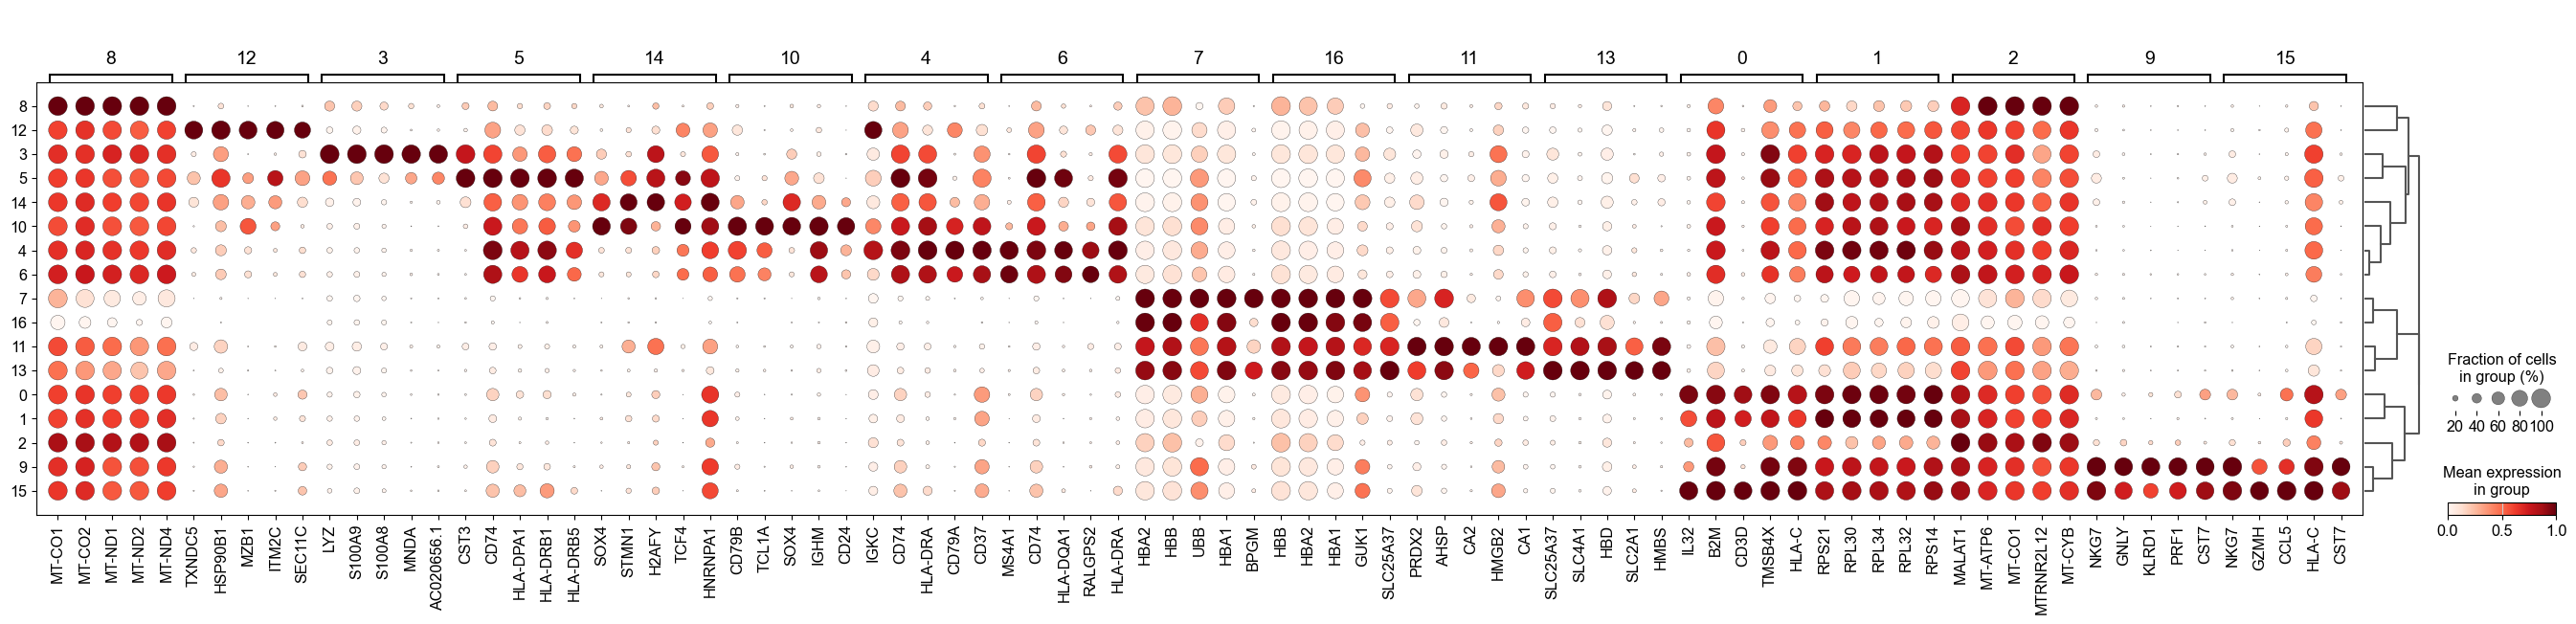

In [32]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby='leiden_res_0.50', standard_scale = 'var', n_genes=5
)

We can then use these genes to figure out what cell types we're looking at. For example, Cluster 7 is expressing NKG7 and GNLY, suggesting these are NK cells.

To create plots or use a more automated approach, the DE genes can be extracted using scanpy.get.rank_genes_groups_df()

In [33]:
sc.get.rank_genes_groups_df(adata, group='7').head(5)

,names,scores,logfoldchanges,pvals,pvals_adj
0,HBA2,67.687675,6.726226,0.0,0.0
1,HBB,67.681541,6.939037,0.0,0.0
2,UBB,67.529060,3.550207,0.0,0.0
3,HBA1,66.808525,6.656751,0.0,0.0
4,BPGM,65.829025,5.023508,0.0,0.0


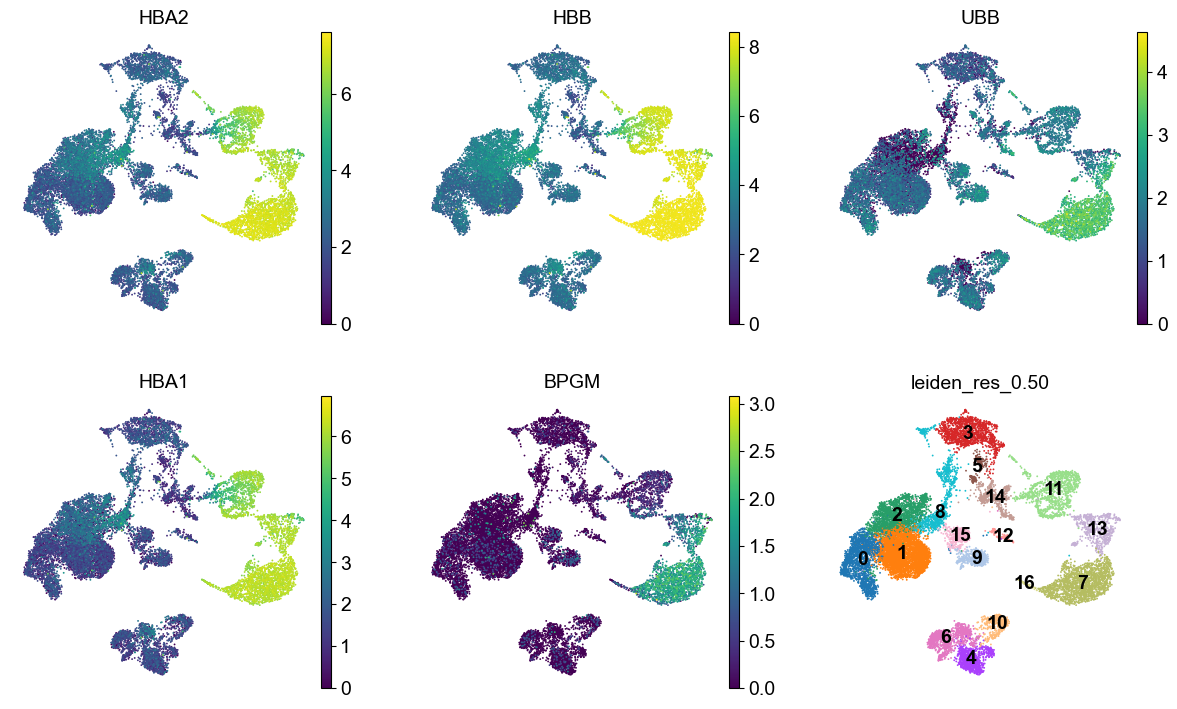

In [34]:
dc_cluster_genes = sc.get.rank_genes_groups_df(adata, group='7').head(5)['names']
sc.pl.umap(
    adata,
    color=[*dc_cluster_genes, 'leiden_res_0.50'],
    legend_loc = 'on data',
    frameon=False,
    ncols=3,
)

One thing to note is that the p-values are extremely low. This is due to the Wilcoxon test being performed considering each cell as an independent sample. For a more conservative approach you may want to consider "pseudo-bulking' your data by sample (e.g. sc.get.aggregate(adata, by=['sample','cell_type'], func='sum', layer='counts'))